# Ca XVII EIS Fitting Procedure

In [1]:
import eispac
import eispac.net
import astropy.modeling
from astropy.modeling.models import Gaussian1D, Polynomial1D
from astropy.modeling.fitting import LevMarLSQFitter
import astropy.table
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

import sunpy.map
from sunpy.net import Fido, attrs as a

This table comes from [Ko et al. (2009)](https://ui.adsabs.harvard.edu/abs/2009ApJ...697.1956K)

In [2]:
fe_11_params = astropy.table.QTable(data={
    'Wavelength': [188.216, 188.299, 192.813, 192.901]*u.AA,
    'Strength': [1.0, 0.70, 0.26, 0.0052],
})
o_5_params = astropy.table.QTable(data={
    'Wavelength': [192.750,192.797,192.801,192.904,192.911,192.915]*u.AA,
    'Strength': [0.1729,0.3193,0.1296,1.0,0.1063,0.00863],
})

In [3]:
fe_11_params

Wavelength,Strength
Angstrom,
float64,float64
188.216,1.0
188.299,0.7
192.813,0.26
192.901,0.0052


In [4]:
o_5_params

Wavelength,Strength
Angstrom,
float64,float64
192.75,0.1729
192.797,0.3193
192.801,0.1296
192.904,1.0
192.911,0.1063
192.915,0.00863


In [5]:
o_5_192_904_model = eispac.core.generate_astropy_model(
    eispac.EISFitTemplate.read_template(
        eispac.data.get_fit_template_filepath('o__05_192_906.2c.template.h5')
    )
)

In [6]:
fe_11_188_216_template = eispac.EISFitTemplate.read_template(
    eispac.data.get_fit_template_filepath('fe_11_188_216.2c.template.h5'))

In [7]:
fe_11_188_216_model = eispac.core.generate_astropy_model(fe_11_188_216_template)
fe_11_188_216_model[0].name = 'Fe XI 188.216'
fe_11_188_216_model[1].name = 'Fe XI 188.299'
fe_11_188_216_model[2].name = 'Background'

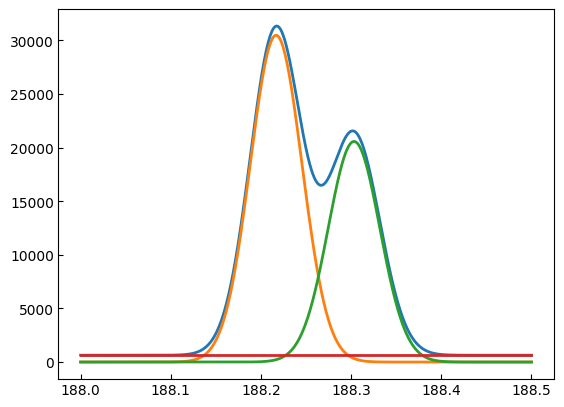

In [8]:
wavelength = np.linspace(188,188.5,1000)
model_init = fe_11_188_216_model(wavelength)
plt.plot(wavelength, model_init)
for component in fe_11_188_216_model:
    plt.plot(wavelength, component(wavelength))

First, we fit our Fe XI 188 model to our raster. We'll use this later to constrain our Fe XI 192 parameters

In [9]:
q = Fido.search(
    a.Time('2007-12-11T15:00:00','2007-12-11T18:00:00'),
    a.Instrument.eis,
    a.Physobs('Intensity'),
    a.Source('Hinode'),
    a.Provider('NRL'),
    a.Level('1'),
    a.eispac.FileType('HDF5 data') | a.eispac.FileType('HDF5 header'),
)

In [10]:
files = Fido.fetch(q)

Files Downloaded:   0%|          | 0/2 [00:00<?, ?file/s]

In [29]:
eis_cube = eispac.read_cube(filename=files[0],
                            window=fe_11_188_216_template.central_wave)

Data file,
   /Users/wtbarnes/sunpy/data/eis_20071211_162413.data.h5
Header file,
   /Users/wtbarnes/sunpy/data/eis_20071211_162413.head.h5
Found a wavelength 188.20 [Angstroms] in window 6
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


<WCSAxes: >

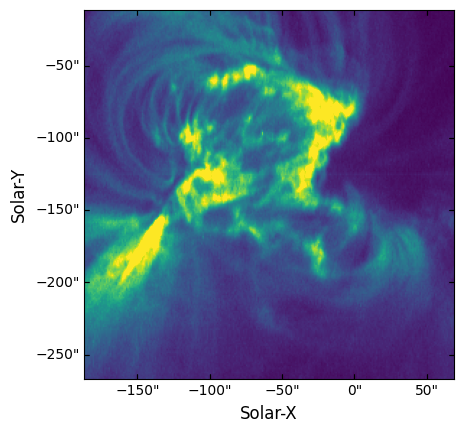

In [30]:
eis_cube[...,12].plot(vmax=2e4)

In [13]:
fe_11_188_216_fit_results = eispac.fit_spectra(eis_cube, fe_11_188_216_template)

 + computing fits for 256 exposures, each with 256 spectra
 + running mpfit on 10 cores (of 10)
 + working on exposure 245

Finished computing fits!
   runtime : 0:00:19.334968
   65536 spectra fit without issues
   0 spectra have < 7 good data points
   0 spectra have bad or invalid parameters


In [14]:
fe_11_188_216_intensity_map = fe_11_188_216_fit_results.get_map(measurement='intensity')

INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


In [31]:
iy,ix = 170,130

In [32]:
fitter = LevMarLSQFitter()

In [38]:
fig = plt.figure()
ax = fig.add_subplot(projection=fe_11_188_216_intensity_map)
fe_11_188_216_intensity_map.plot(axes=ax)
ax.plot(ix,iy,color='r',marker='x', markersize=10, ls='')

NameError: name 'fe_11_188_216_intensity_map' is not defined

<Figure size 640x480 with 0 Axes>

In [33]:
fitted_model = fitter(fe_11_188_216_model,eis_cube.wavelength[iy,ix,:],eis_cube.data[iy,ix,:],)

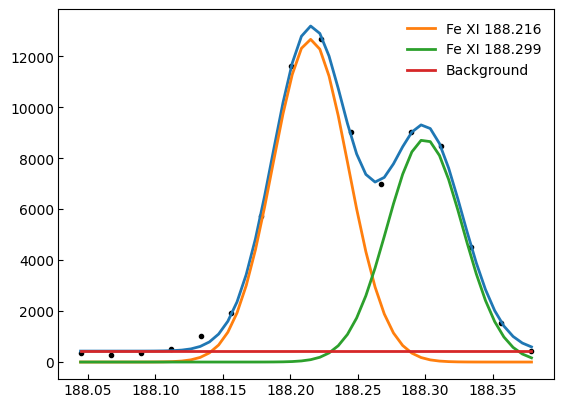

In [34]:
wavelength_data = eis_cube.wavelength[iy,ix,:]
wavelength_smooth = np.linspace(*wavelength_data[[0,-1]],50)
fitted_line = fitted_model(wavelength_smooth)
plt.plot(wavelength_data, eis_cube.data[iy,ix,:], color='k', marker='.', ls='')
plt.plot(wavelength_smooth, fitted_line)
for component in fitted_model:
    plt.plot(wavelength_smooth, component(wavelength_smooth), label=component.name)
#plt.yscale('log')
#plt.ylim(1e-1,1e4)
plt.legend()

In [45]:
#fe_11_188_216_amplitude = fe_11_188_216_fit_results.fit['params'][iy,ix,0]
#fe_11_188_216_mean = fe_11_188_216_fit_results.fit['params'][iy,ix,1]
#fe_11_188_216_width = fe_11_188_216_fit_results.fit['params'][iy,ix,2]
fe_11_188_216_amplitude = fitted_model[0].amplitude
fe_11_188_216_mean = fitted_model[0].mean
fe_11_188_216_width = fitted_model[0].stddev

Let's build a compound model for our Ca XVII fit

First, set up all of the Gaussians and the background

In [46]:
fe_11_models = None
for line in fe_11_params[2:]:
    offset = line['Wavelength'] - fe_11_params['Wavelength'][0]
    _component = Gaussian1D(amplitude=fe_11_188_216_amplitude*line['Strength'],
                            stddev=fe_11_188_216_width,
                            mean=fe_11_188_216_mean+offset.to_value('Angstrom'),
                            fixed={'amplitude': True, 'mean': True, 'stddev': True},
                            name=f'Fe XI {line["Wavelength"].value:.3f}')
    if fe_11_models is None:
        fe_11_models = _component
    else:
        fe_11_models += _component

In [47]:
o_5_amplitude_guess = fe_11_models[0].amplitude.value/10  # o_5_192_904_model[1].amplitude.value
o_5_width_guess = fe_11_models[0].stddev.value  # o_5_192_904_model[1].stddev.value

In [48]:
o_5_models = None
for line in o_5_params:
    offset = line['Wavelength'] - o_5_params['Wavelength'][3]
    _component = Gaussian1D(amplitude=o_5_amplitude_guess*line['Strength'],
                            stddev=o_5_width_guess,
                            mean=(o_5_params['Wavelength'][3] + offset).to_value('Angstrom'),
                            name=f'O V {line["Wavelength"].value:.3f}')
    if o_5_models is None:
        o_5_models = _component
    else:
        o_5_models += _component

In [49]:
ca_17_192_858_model = eispac.core.generate_astropy_model(
    eispac.EISFitTemplate.read_template(
        eispac.data.get_fit_template_filepath('ca_17_192_858.1c.template.h5')
    )
)
ca_17_192_858_model[0].amplitude = ca_17_192_858_model[0].amplitude/20
ca_17_192_858_model[0].mean = 192.858
ca_17_192_858_model[0].name = 'Ca XVII 192.858'
ca_17_192_858_model[1].name = 'Background'

In [50]:
ca_17_full_model = fe_11_models + o_5_models + ca_17_192_858_model
#ca_17_full_model[-1].c0 = 100

Now, specify the tying in the O V lines

In [51]:
for _component,row in zip(o_5_models,o_5_params):
    if row['Strength'] < 1.0:
        _component.amplitude.tied = lambda x: row['Strength']*x.amplitude_5
        _component.mean.tied = lambda x: x.mean_5 + (row['Wavelength'] - o_5_params['Wavelength'][3]).to_value('AA')
        _component.stddev.tied = lambda x: x.stddev_5

Then the bounds. We need only specify these on the free parameters.

In [52]:
o_5_models[3].amplitude.min = 0
o_5_models[3].mean.min = o_5_models[3].mean - 0.04
o_5_models[3].mean.max = o_5_models[3].mean + 0.04
o_5_models[3].stddev.min = 0.02 #o_5_models[3].stddev*0.5
o_5_models[3].stddev.max = 0.045 #o_5_models[3].stddev*2
ca_17_full_model[-2].amplitude.min = 0
ca_17_full_model[-2].mean.min = ca_17_full_model[-2].mean - 0.04
ca_17_full_model[-2].mean.max = ca_17_full_model[-2].mean + 0.04
ca_17_full_model[-2].stddev.min = 0.02 #ca_17_full_model[-2].stddev*0.5
ca_17_full_model[-2].stddev.max = 0.045 #ca_17_full_model[-2].stddev*2

In [42]:
for component in ca_17_full_model:
    print('---------')
    print(component)
    print(component.tied)
    print(component.fixed)

---------
Model: Gaussian1D
Name: Fe XI 192.813
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            mean               stddev       
    ----------------- ------------------ --------------------
    3294.194704669912 192.81197530431984 0.028061899248665523
{'amplitude': False, 'mean': False, 'stddev': False}
{'amplitude': True, 'mean': True, 'stddev': True}
---------
Model: Gaussian1D
Name: Fe XI 192.901
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            mean               stddev       
    ----------------- ------------------ --------------------
    65.88389409339823 192.89997530431987 0.028061899248665523
{'amplitude': False, 'mean': False, 'stddev': False}
{'amplitude': True, 'mean': True, 'stddev': True}
---------
Model: Gaussian1D
Name: O V 192.750
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude      mean         stddev       
    ----------------- ------ ------------------

In [53]:
eis_cube = eispac.read_cube(files[0], window=ca_17_full_model[-2].mean.value)

Data file,
   /Users/wtbarnes/sunpy/data/eis_20071211_162413.data.h5
Header file,
   /Users/wtbarnes/sunpy/data/eis_20071211_162413.head.h5
Found a wavelength 192.86 [Angstroms] in window 7
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


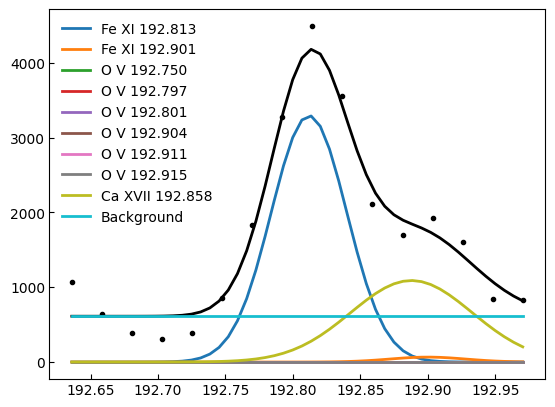

In [54]:
fitted_model = fitter(ca_17_full_model, eis_cube.wavelength[iy,ix,:], eis_cube.data[iy,ix,:])
wavelength_data = eis_cube.wavelength[iy,ix,:]
wavelength_smooth = np.linspace(*wavelength_data[[0,-1]],50)
fitted_line = fitted_model(wavelength_smooth)
plt.plot(wavelength_data, eis_cube.data[iy,ix,:], color='k', marker='.', ls='')
plt.plot(wavelength_smooth, fitted_line, color='k')
for component in fitted_model:
    plt.plot(wavelength_smooth, component(wavelength_smooth), label=component.name)
#plt.yscale('log')
#plt.ylim(1e-1,1e4)
plt.legend()

In [28]:
for component in ca_17_full_model:
    print('---------')
    print(component.)

---------
Model: Gaussian1D
Name: Fe XI 192.813
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            mean               stddev       
    ----------------- ------------------ --------------------
    3294.194704669912 192.81197530431984 0.028061899248665523
---------
Model: Gaussian1D
Name: Fe XI 192.901
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            mean               stddev       
    ----------------- ------------------ --------------------
    65.88389409339823 192.89997530431987 0.028061899248665523
---------
Model: Gaussian1D
Name: O V 192.750
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude      mean         stddev       
    ----------------- ------ --------------------
    56.95662644374278 192.75 0.028061899248665523
---------
Model: Gaussian1D
Name: O V 192.797
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude        mean         stddev  